# Import modules

In [1]:
import scanpy as sc
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import ktplotspy as kpy

import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 

import os 
from matplotlib.patches import Rectangle
import itertools

In [2]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [3]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024'
table_dir = '/nfs/team205/heart/fetal_ms_figures/tables/Aug2024'

# Variables

In [4]:
niche_of_interest = 'SAnode'
path_to_cpdb = f'/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/cellphonedb/HEA_FOET14880396/{niche_of_interest}'
path_to_adata = f'/lustre/scratch126/cellgen/team205/kk18/VisiumHD/objects/cellphonedb/HEA_FOET14880396/inputs/log_norm_counts_{niche_of_interest}.h5ad'
celltype_col = 'fine_grain_4Jan2025'

# Read in input adata

In [5]:
# read in adata
adata = sc.read_h5ad(path_to_adata)
adata

AnnData object with n_obs × n_vars = 1289 × 18047
    obs: 'object_id', 'bin_count', 'array_row', 'array_col', 'labels_joint_source', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'celltypist_coarse', 'conf_score_coarse', 'celltypist_coarse_fin', 'celltypist_coarse2midmod', 'conf_score_coarse2midmod', 'celltypist_mid_fin', 'celltypist_midmod2fine', 'conf_score_midmod2fine', 'fine_grain_4Jan2025', 'HistologicalAnnotation', 'cluster_cellcharter_k-8', 'cluster_cellcharter_k-10', 'cluster_cellcharter_k-12', 'cluster_cellcharter_k-14', 'cluster_cellcharter_k-16', 'cluster_cellcharter_k-18', 'cluster_cellcharter_k-20', 'cluster_cellcharter_k-25', 'cluster_cellcharter_k-30', 'cluster_cellcharter_k-35', 'cluster_cellcharter_k-40', 'cluster_cellcharter_k-45', 'cluster_cellch

# Read in cpdb outputs

In [8]:
timestamp = '05_04_2025_105025'
timestamp

'05_04_2025_105025'

In [9]:
# read in
cpdbout_means =  pd.read_table(f'{path_to_cpdb}/statistical_analysis_means_{timestamp}.txt',index_col=0)
cpdbout_pvals =  pd.read_table(f'{path_to_cpdb}/statistical_analysis_pvalues_{timestamp}.txt',index_col=0)
cpdbout_sigmeans =  pd.read_table(f'{path_to_cpdb}/statistical_analysis_significant_means_{timestamp}.txt',index_col=0)
interaction_metadata = pd.read_csv('/nfs/team205/heart/cellphonedb/customDB/interaction_meta/interaction_metadata_v5.0.0_2024-1-26.csv')

In [10]:
# add gene names to cpdb outputs
cpdbout_means['gene_name_1'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_means.index,'gene_name_1'])
cpdbout_means['gene_name_2'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_means.index,'gene_name_2'])
cpdbout_pvals['gene_name_1'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_pvals.index,'gene_name_1'])
cpdbout_pvals['gene_name_2'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_pvals.index,'gene_name_2'])
cpdbout_sigmeans['gene_name_1'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_sigmeans.index,'gene_name_1'])
cpdbout_sigmeans['gene_name_2'] = list(interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_sigmeans.index,'gene_name_2'])

In [11]:
# insert gene_name columns to the cpdb output
# to select interactions based on the list
cpdbout_means[['gene_name_1','gene_name_2']] = interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_means.index,['gene_name_1','gene_name_2']]
cpdbout_pvals[['gene_name_1','gene_name_2']] = interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_pvals.index,['gene_name_1','gene_name_2']]
cpdbout_sigmeans[['gene_name_1','gene_name_2']] = interaction_metadata.set_index('id_cp_interaction').loc[cpdbout_sigmeans.index,['gene_name_1','gene_name_2']]

In [12]:
# query a gene, to check of the existence of the its interactions in the database
gene = 'FGF10'
mask1 = [gene in x.split(',') for x in interaction_metadata['gene_name_1']]
mask2 = [gene in x.split(',') for x in interaction_metadata['gene_name_2']]
mask = [any(x) for x in zip(mask1,mask2)]
interaction_metadata[mask][['id_cp_interaction','gene_name_1','gene_name_2']]

,id_cp_interaction,gene_name_1,gene_name_2
934,CPI-SS0AECC113F,FGF10,FGFR2


# Plot

### Receptor expressed in PSNS

In [14]:
receptor_genes = [
    # Netrin receptors
    "DCC", "NEO1", "UNC5A", "UNC5B", "UNC5C", "UNC5D",
    # Slit (Robo) receptors
    "ROBO1", "ROBO2", "ROBO3", "ROBO4",
    # Semaphorin receptors
    "NRP1", "NRP2",
    "PLXNA1", "PLXNA2", "PLXNA3", "PLXNA4",
    "PLXNB1", "PLXNB2", "PLXNB3",
    "PLXNC1", "PLXND1",
    # Ephrin (Eph) receptors
    "EPHA1", "EPHA2", "EPHA3", "EPHA4", "EPHA5", "EPHA6", "EPHA7", "EPHA8", "EPHA10",
    "EPHB1", "EPHB2", "EPHB3", "EPHB4", "EPHB6",
    # Neurotrophin / GDNF family receptors
    "NTRK1", "NTRK2", "NTRK3", "NGFR", "RET",
    "GFRA1", "GFRA2", "GFRA3", "GFRA4",
    # Neuregulin (ErbB) receptors
    "ERBB2", "ERBB3", "ERBB4",
    # Additional innervation‑related receptors
    "EDNRB", "LRP8", "VLDLR", "L1CAM", "NCAM1",
    # Others
    "CXCR4","CNTNAP4","FGFR2"
]
receptor_celltype = 'ParaN'

# ligand_genes = ['SEMA3A', 'SLIT2', 'SLIT3', 'EFNB2', 'CXCL12', 'FGF10', 'VEGFC', 'NELL1']
ligand_celltypes = ['SHPC','SANPCHd','SANPCTl','aCMR']

In [15]:
def receiving_signal(
    cpdbout_means,
    cpdbout_pvals,
    receptor_celltype,
    receptor_genes,
    ligand_celltypes=None
):
    # Subset results
    
    ### get columns
    cellpair_cols = [x for x in cpdbout_means.columns if '|' in x]
    other_cols = [x for x in cpdbout_means.columns if '|' not in x]
    
    ### get dataframe which has receptor_celltype and the receptor_genes at the "b/2" side (majority will be like this)
    mask_row = (
        cpdbout_means['gene_name_2']
        .str.split(',')
        .apply(lambda names: any(g in receptor_genes for g in names))
    )
    if ligand_celltypes!=None:
        cellpair_cols_sel = [x for x in cellpair_cols if (f'|{receptor_celltype}' in x)&(x.split('|')[0] in ligand_celltypes)]
    else:
        cellpair_cols_sel = [x for x in cellpair_cols if (f'|{receptor_celltype}' in x)]
    col_sel = other_cols + cellpair_cols_sel
    means_2 = cpdbout_means.loc[mask_row, col_sel]
    pvals_2 = cpdbout_pvals.loc[mask_row, col_sel]

    ### get dataframe which has receptor_celltype and the receptor_genes at the "a/1" side
    mask_row = (
        cpdbout_means['gene_name_1']
        .str.split(',')
        .apply(lambda names: any(g in receptor_genes for g in names))
    )
    if ligand_celltypes!=None:
        cellpair_cols_sel = [x for x in cellpair_cols if (f'{receptor_celltype}|' in x)&(x.split('|')[1] in ligand_celltypes)]
    else:
        cellpair_cols_sel = [x for x in cellpair_cols if (f'{receptor_celltype}|' in x)]
    col_sel = other_cols + cellpair_cols_sel
    means_1 = cpdbout_means.loc[mask_row, col_sel]
    pvals_1 = cpdbout_pvals.loc[mask_row, col_sel]
    # remove rows which are already exist in means_2
    index_keep = list(set(means_1.index)-set(means_2.index))
    means_1 = means_1.loc[index_keep]
    pvals_1 = pvals_1.loc[index_keep]
    # reverse gene_a and gene_b
    mapper = {'partner_a':'partner_b',
              'partner_b':'partner_a',
              'gene_a':'gene_b',
              'gene_b':'gene_a',
              'receptor_a':'receptor_b',
              'receptor_b':'receptor_a',
              'directionality':'directionality_reverse'}
    means_1.rename(columns=mapper,inplace=True)
    pvals_1.rename(columns=mapper,inplace=True)

    new_columns = []
    for col in means_1.columns:
        if '|' in col:
            cell_a = col.split('|')[0]
            cell_b = col.split('|')[1]
            new_columns.append(f'{cell_b}|{cell_a}')
        else:
            new_columns.append(col)
    means_1.columns = new_columns
    pvals_1.columns = new_columns

    new_interacting_pair = []
    for ind in means_1.index:
        partner_a = means_1.loc[ind,'partner_a']
        partner_b = means_1.loc[ind,'partner_b']
        if 'complex:' in partner_a:
            partner_a = partner_a.replace('complex:','')
        else:
            partner_a = means_1.loc[ind,'gene_a']
        if 'complex:' in partner_b:
            partner_b = partner_b.replace('complex:','')
        else:
            partner_b = means_1.loc[ind,'gene_b']
        new_interacting_pair.append(f'{partner_a}_{partner_b}')
    means_1['interacting_pair'] = new_interacting_pair
    pvals_1['interacting_pair'] = new_interacting_pair

    ### concatenate
    means = pd.concat([means_2,means_1])
    pvals = pd.concat([pvals_2,pvals_1])

    ### remove NaN
    means = means.dropna(axis=0, how='all')
    means = means.dropna(axis=1, how='all')
    pvals = pvals.dropna(axis=0, how='all')
    pvals = pvals.dropna(axis=1, how='all')

    ### formatting
    means = means.reset_index()
    pvals = pvals.reset_index()
    means.drop(labels=['gene_name_1','gene_name_2','directionality_reverse'],axis=1,inplace=True)
    pvals.drop(labels=['gene_name_1','gene_name_2','directionality_reverse'],axis=1,inplace=True)
    
    return means, pvals

/software/cellgen/team205/kk18/envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5.2 x 9 in image.
/software/cellgen/team205/kk18/envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024/VisiumHD_CellPhoneDB_SAN_CM-AxonG-to-ParaN_all-ligands.pdf


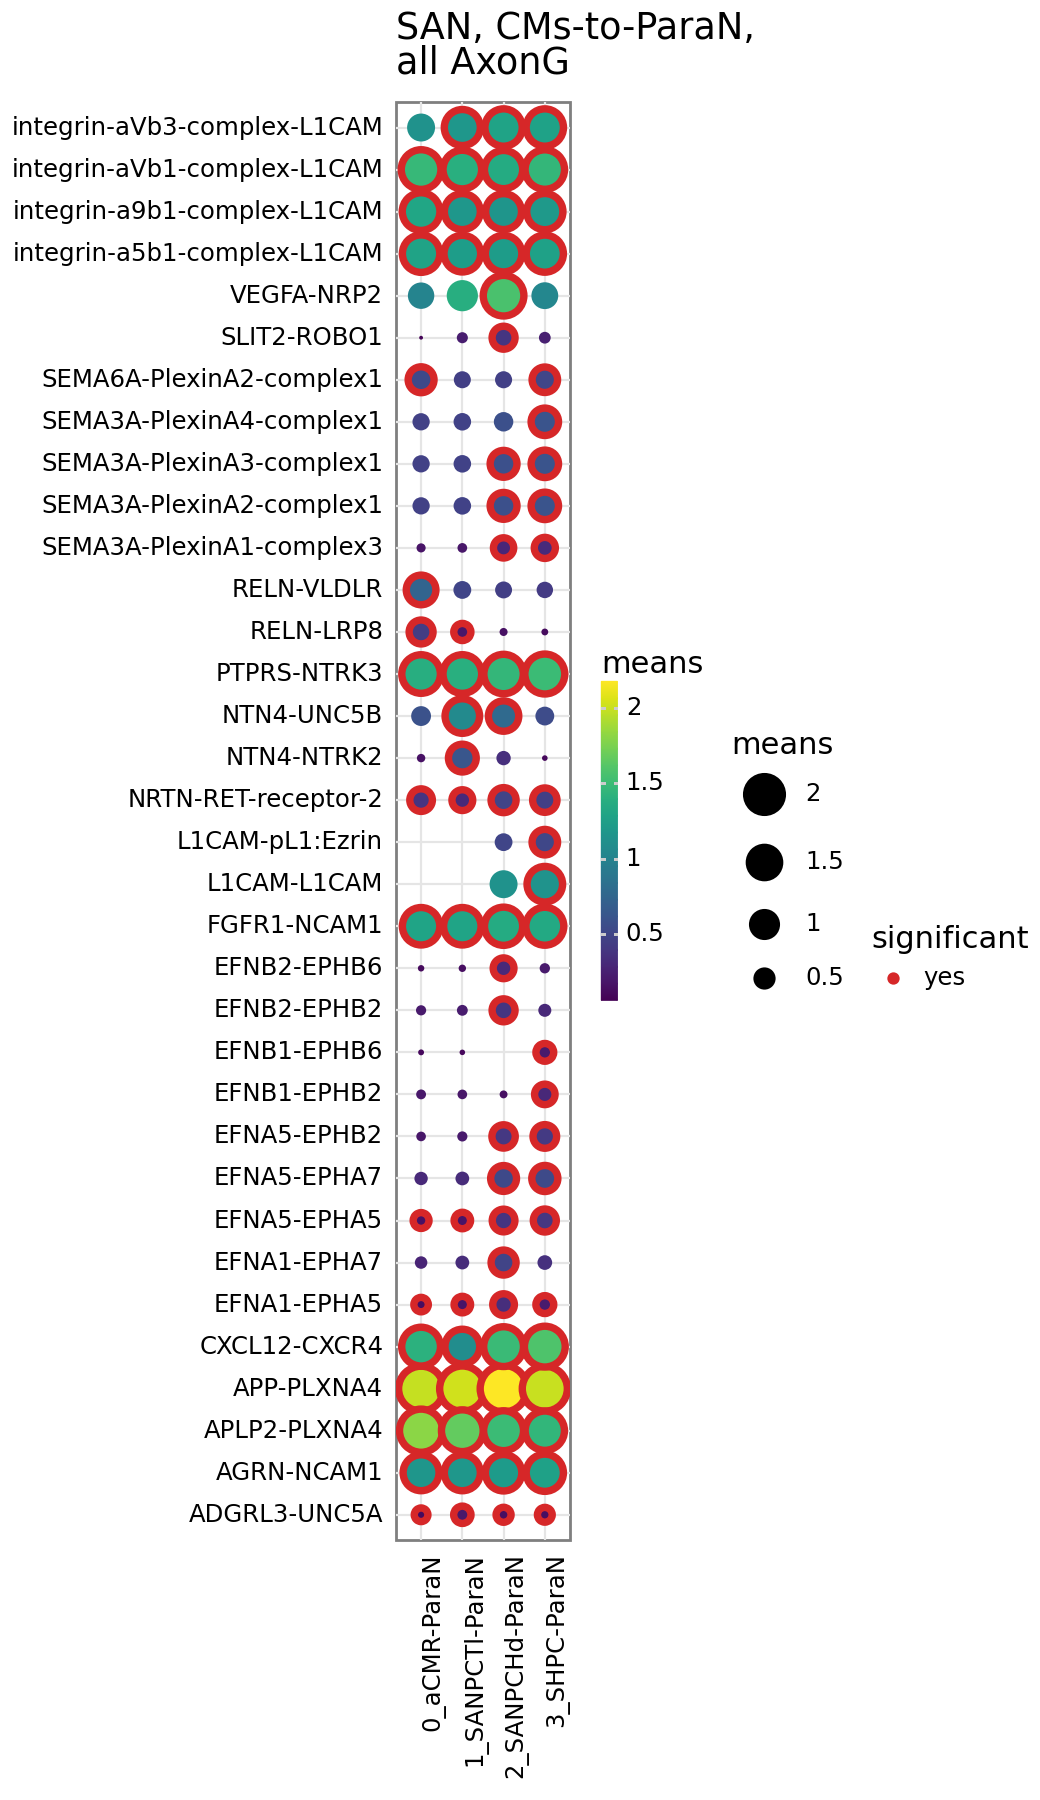

<Figure Size: (520 x 900)>

In [16]:
means,pvals = receiving_signal(
    cpdbout_means,
    cpdbout_pvals,
    receptor_celltype,
    receptor_genes,
    ligand_celltypes=ligand_celltypes
)

# reorder interaction columns
non_interaction_columns = [x for x in means.columns if '|' not in x]
interaction_columns = [f'{x}|ParaN' for x in ligand_celltypes[::-1]]
means = means[non_interaction_columns+interaction_columns]
pvals = pvals[non_interaction_columns+interaction_columns]
interaction_columns = [f'{i}_{x}|ParaN' for i,x in enumerate(ligand_celltypes[::-1])]
means.columns = non_interaction_columns+interaction_columns
pvals.columns = non_interaction_columns+interaction_columns

# rename cell types of interest for regulating the order
for i,cell in enumerate(ligand_celltypes[::-1]):
    adata.obs.replace({celltype_col:{cell:f'{i}_{cell}'}},inplace=True)

plot = kpy.plot_cpdb(
    adata=adata,
    cell_type1='.',
    cell_type2='.',  # this means all cell-types
    means=means,
    pvals=pvals,
    alpha=0.1,
    celltype_key=celltype_col,
    genes=None,
    figsize=(5.2, 9),
    title='SAN, CMs-to-ParaN,\nall AxonG',
    highlight_size =1.5,
    standard_scale=False
)
plot.save(f"{figdir}/VisiumHD_CellPhoneDB_SAN_CM-AxonG-to-ParaN_all-ligands.pdf", bbox_inches="tight",dpi=300)
plot

# Slect interactions specific to Sinus Horn and SAN

In [18]:
# select interactions only significant at SHPC or SANPCs
pval_thresh = 0.1
mask = pvals['0_aCMR|ParaN'] > pval_thresh
means = means.loc[mask]
pvals = pvals.loc[mask]

/software/cellgen/team205/kk18/envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5.2 x 5.5 in image.
/software/cellgen/team205/kk18/envs/cpdb/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /nfs/team205/heart/fetal_ms_figures/raw_plots_kk/Aug2024/VisiumHD_CellPhoneDB_SAN_CM-AxonG-to-ParaN_selected.pdf


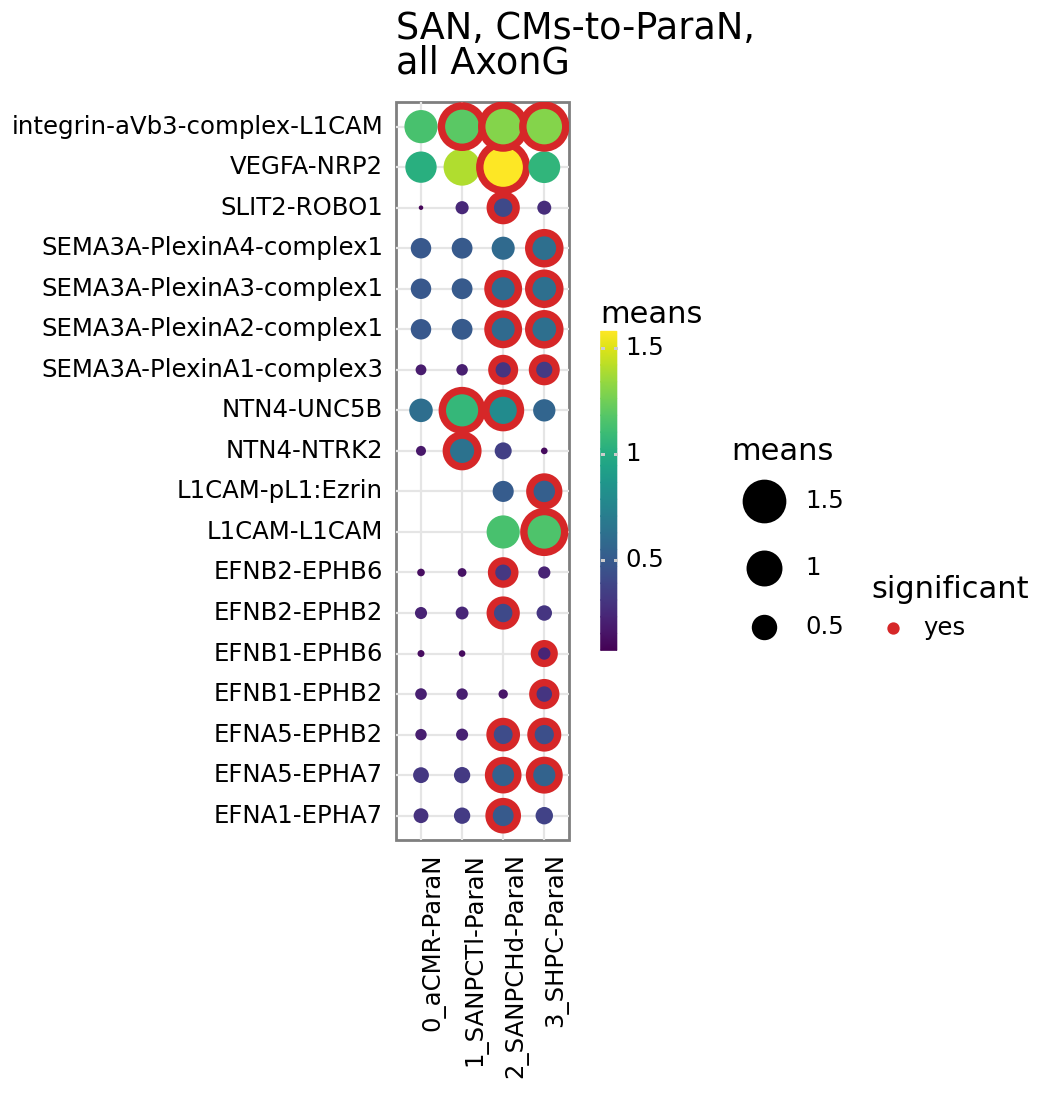

<Figure Size: (520 x 550)>

In [19]:
plot = kpy.plot_cpdb(
    adata=adata,
    cell_type1='.',
    cell_type2='.',  # this means all cell-types
    means=means,
    pvals=pvals,
    alpha=0.1,
    celltype_key=celltype_col,
    genes=None,
    figsize=(5.2, 5.5),
    title='SAN, CMs-to-ParaN,\nall AxonG',
    highlight_size =1.5,
    standard_scale=False
)
plot.save(f"{figdir}/VisiumHD_CellPhoneDB_SAN_CM-AxonG-to-ParaN_selected.pdf", bbox_inches="tight",dpi=300)
plot